<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

<a href="http://www.math.univ-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo_imt.jpg" style="float:right; max-width: 250px; display: inline" alt="IMT"/> </a>
</center>

## Chatbot: catégorisations et prévisions des réponses aux questions

# Text Mining et Catégorisation de Produits en <a href="https://www.python.org/"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Python_logo_and_wordmark.svg/390px-Python_logo_and_wordmark.svg.png" style="max-width: 120px; display: inline" alt="R"/></a> avec <a href="http://scikit-learn.org/stable/#"><img src="http://scikit-learn.org/stable/_static/scikit-learn-logo-small.png" style="max-width: 100px; display: inline" alt="R"/></a>

## Introduction

Il s'agit de prévoir la réponse à une question à partir de son sujet. Seule la catégorie principale (1er niveau) est prédite mais nous pourrons essayer d'affiner par la suite. L'objectif est plutôt de comparer les performances des méthodes et technologies en fonction de la taille de la base d'apprentissage ainsi que d'illustrer sur un exemple complexe le prétraitement de données textuelles. La stratégie de sous ou sur échantillonnage des catégories qui permet d'améliorer la prévision va être mise en oeuvre. Nous allons essayer différentes techniques d'échantillonnage comme le regroupement de plusieurs catégories en fonction de leur points communs ou selon leur taille puis nous essayerons de mettre en place un mélange de upsampling et de downsampling.
* Nous allons réduire l'échantillon réduit en le séparant en 2 parties: apprentissage et validation. 
* Les données textuelles sont  nettoyées, racinisées, vectorisées avant modélisation.
* Trois modélisations sont estimées: logistique, arbre, forêt aléatoire.
* Optimiser l'erreur en faisant varier différents paramètres: types et paramètres de vectorisation (TF-IDF), paramètres de la régression logistique (pénalisation l1) et de la forêt aléatoire (nombre d'arbres et nombre de variables aléatoire).

Exécuter finalement le code pour différentes tailles (paramètre  `tauxTot` ci-dessous) de l'échantillon d'apprentissage et comparer les qualités de prévision obtenues. 

In [1]:
#Importation des librairies utilisées
import unicodedata 
import time
import pandas as pd
import numpy as np
import random
import nltk
import collections
import itertools
import csv
import warnings

from sklearn.cross_validation import train_test_split

/usr/local/insa/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

## 1. Importation des données
Définition du répertoir de travail, des noms des différents fichiers utilisés et des variables globales.


In [16]:
# Répertoire de travail
DATA_DIR = "/home/bouchero/Documents/projet/"

# Nom des fichiers
training_reduit_path = DATA_DIR + "INSA_wefight_data_clean.csv"
# Variable Globale
HEADER_TEST = ['Question','Intent','BlockId', 'Action']
HEADER_TRAIN =['Question','Intent','BlockId', 'Action']

In [17]:
## Si nécessaire (première exécution) chargement de nltk, librairie pour la suppression 
## des mots d'arrêt et la racinisation
## nltk.download()

   ### Read & Split Dataset
   Fonction permettant de lire le fichier d'apprentissage et de créer deux DataFrame Pandas, un pour l'apprentissage, l'autre pour la validation.
   La première méthode créée un DataFrame en lisant entièrement le fichier. Puis elle scinde le DataFrame en deux  grâce à la fonction dédiée de sklearn. 

In [18]:
def split_dataset(input_path, nb_line, tauxValid,columns):
    time_start = time.time()
    data_all = pd.read_csv(input_path,sep=",",names=columns,nrows=nb_line) #cree data frame
    data_all = data_all.fillna("") #remplace les na par " "
    data_train, data_valid = train_test_split(data_all, test_size = tauxValid) # Split arrays or matrices into random train and test subsets
    time_end = time.time()
    print("Split Takes %d s" %(time_end-time_start))
    return data_train, data_valid

nb_line=20000  # part totale extraite du fichier initial ici déjà réduit
tauxValid=0.10 # part totale extraite du fichier initial ici déjà réduit
data_train, data_valid = split_dataset(training_reduit_path, nb_line, tauxValid, HEADER_TRAIN)
# Cette ligne permet de visualiser les 5 premières lignes de la DataFrame 
data_train.head(5)

Split Takes 0 s


,Question,Intent,BlockId,Action
4505,ca veut dire quoi intrapéritonéal ?,#6-9_TRTEINS_ChimioIntraperitoneale,59632c41e4b0a226d067cca8,wiki_cancer#
3074,quelle crème prendre pour hydrater sa peau,#6-49_TRTEINS_Peau,59918cf1e4b0feb28881fd9f,wiki_cancer
1693,j'ai un manque d'énergie,#2-64-0_QVDP_Fatigue,59942265e4b068eebf52bb9f,wiki_cancer
4767,merci ma maman est dcd de ca je fais une mamo ...,#9-53_Depistage_cancer_sein,59632c41e4b0a226d067cb23,wiki_cancer
2977,Maquillage,#6-49_TRTEINS_Peau,59918cf1e4b0feb28881fd9f,wiki_cancer


## 2. Nettoyage des données
Afin de limiter la dimension de l'espace des variables ou *features*, tout en conservant les informations essentielles, il est nécessaire de nettoyer les données en appliquant plusieurs étapes:
* Chaque mot est écrit en minuscule.
* Les termes numériques, de ponctuation et autres symboles sont supprimés.
* 155 mots-courants, et donc non informatifs, de la langue française sont supprimés (STOPWORDS). Ex: le, la, du, alors, etc...
* Chaque mot est "racinisé", via la fonction `STEMMER.stem` de la librairie nltk. La racinisation transforme un mot en son radical ou sa racine. Par exemple, les mots: cheval, chevaux, chevalier, chevalerie, chevaucher sont tous remplacés par "cheva".

### Importation des librairies et fichier pour le nettoyage des données.

In [19]:
# Librairies 
from bs4 import BeautifulSoup #Nettoyage d'HTML
import re # Regex
import nltk # Nettoyage des données

## listes de mots à supprimer dans la description des produits
## Depuis NLTK
nltk_stopwords = nltk.corpus.stopwords.words('french') 
## Depuis Un fichier externe.
lucene_stopwords = [unicode(w, "utf-8") for w in open(DATA_DIR+"lucene_stopwords.txt").read().split(",")] #En local

## Union des deux fichiers de stopwords 
stopwords = list(set(nltk_stopwords).union(set(lucene_stopwords)))

## Fonction de setmming de stemming permettant la racinisation
stemmer=nltk.stem.SnowballStemmer('french')

### Fonction de nettoyage de texte
Fonction qui prend en intrée un texte et retourne le texte nettoyé en appliquant successivement les étapes suivantes: Nettoyage des données HTML, conversion en texte minuscule, encodage uniforme, suppression des caractéres non alpha numérique (ponctuations), suppression des stopwords, racinisation de chaque mot individuellement.

In [20]:
# remarque
#'a b c'.split()
#str.split('a b c')
# both return ['a', 'b', 'c']

In [21]:
# Fonction clean générale
def clean_txt(txt):
    ### remove html stuff
    txt = BeautifulSoup(txt,"html.parser",from_encoding='utf-8').get_text() #nettoyage donnee html
    ### lower case
    txt = txt.lower()
    ### special escaping character '...'
    txt = txt.replace(u'\u2026','.')
    txt = txt.replace(u'\u00a0',' ')
    ### remove accent btw
    txt = unicodedata.normalize('NFD', txt).encode('ascii', 'ignore')
    ###txt = unidecode(txt)
    ### remove non alphanumeric char
    txt = re.sub('[^a-z_]', ' ', txt)
    ### remove french stop words
    tokens = [w for w in txt.split() if (len(w)>2) and (w not in stopwords)]
    ### french stemming
    tokens = [stemmer.stem(token) for token in tokens]
    #Stemmers remove morphological affixes from words, leaving only the word stem
    ### tokens = stemmer.stemWords(tokens)
    return ' '.join(tokens)
    #join() returns a string in which the string elements of sequence have been joined by str separator.

def clean_marque(txt):
    txt = re.sub('[^a-zA-Z0-9]', '_', txt).lower()
    return txt

### Nettoyage des DataFrames
Applique le nettoyage sur toutes les lignes de la DataFrame

In [22]:
# fonction de nettoyage du fichier(stemming et liste de mots à supprimer)
def clean_df(input_data, column_names= ['Question','Intent','BlockId', 'Action']):
    #Test if columns entry match columns names of input data
    column_names_diff= set(column_names).difference(set(input_data.columns))
    #set.difference   new set with elements in column_names but not in input_data.columns
    
    if column_names_diff: #rentre dans la boucle si column_names différent zero
        # warning = exception
        warnings.warn("Column(s) '"+", ".join(list(column_names_diff)) +"' do(es) not match columns of input data", Warning)
        
    nb_line = input_data.shape[0]
    print("Start Clean %d lines" %nb_line)
    
    # Cleaning start for each columns
    time_start = time.time()
    clean_list=[]
    for column_name in column_names:
        column = input_data[column_name].values
        if column_name == "Question":
            array_clean = np.array(map(clean_txt,column))
            
        elif column_name == "Intent":
            array_clean = np.asarray(input_data['Intent']) #on recopie telle quelle la colonne intent  
            
        else:
            array_clean = np.array(map(clean_marque,column))
            #applies a function to all the items in an input_list
            #map(function_to_apply, list_of_inputs)
        clean_list.append(array_clean)
    time_end = time.time()
    print("Cleaning time: %d secondes"%(time_end-time_start))
    
    #Convert list to DataFrame
    array_clean = np.array(clean_list).T
    data_clean = pd.DataFrame(array_clean, columns = column_names)
    return data_clean

In [24]:
# Take approximately 2 minutes fors 100.000 rows
data_valid_clean = clean_df(data_valid)
data_train_clean = clean_df(data_train)

Start Clean 502 lines
Cleaning time: 0 secondes
Start Clean 4511 lines
Cleaning time: 1 secondes


Affiche les 5 premières lignes de la DataFrame d'apprentissage après nettoyage.

In [25]:
#info sur les données
data_train_clean.info()
data_train_clean.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4511 entries, 0 to 4510
Data columns (total 4 columns):
Question    4511 non-null object
Intent      4511 non-null object
BlockId     4511 non-null object
Action      4511 non-null object
dtypes: object(4)
memory usage: 141.0+ KB


,Question,Intent,BlockId,Action
0,veut dir intraperitoneal,#6-9_TRTEINS_ChimioIntraperitoneale,59632c41e4b0a226d067cca8,wiki_cancer_
1,crem prendr hydrat peau,#6-49_TRTEINS_Peau,59918cf1e4b0feb28881fd9f,wiki_cancer
2,manqu energ,#2-64-0_QVDP_Fatigue,59942265e4b068eebf52bb9f,wiki_cancer
3,maman dcd fais mamo deux an jai an,#9-53_Depistage_cancer_sein,59632c41e4b0a226d067cb23,wiki_cancer
4,maquillag,#6-49_TRTEINS_Peau,59918cf1e4b0feb28881fd9f,wiki_cancer


In [26]:
data_train_clean

,Question,Intent,BlockId,Action
0,veut dir intraperitoneal,#6-9_TRTEINS_ChimioIntraperitoneale,59632c41e4b0a226d067cca8,wiki_cancer_
1,crem prendr hydrat peau,#6-49_TRTEINS_Peau,59918cf1e4b0feb28881fd9f,wiki_cancer
2,manqu energ,#2-64-0_QVDP_Fatigue,59942265e4b068eebf52bb9f,wiki_cancer
3,maman dcd fais mamo deux an jai an,#9-53_Depistage_cancer_sein,59632c41e4b0a226d067cb23,wiki_cancer
4,maquillag,#6-49_TRTEINS_Peau,59918cf1e4b0feb28881fd9f,wiki_cancer
5,boutiqu achet perruqu,#2-49_QVDP_Alopecie_OuPerruque,598439eae4b03f0d12f637ea,wiki_cancer
6,peux fair sport lymphoedem,#6-34_TRTEINS_Lymphoedeme,598b4f84e4b03f0d37111d5d,wiki_cancer
7,toxicit chimiotherap beb,#2-109_QVDP_Grossesse_Chimiotherapie,598d6e70e4b03f0d40baca04,wiki_cancer
8,aphte aliment,#6-53_TRTEINS_Aphtes,59918dbae4b0feb28887a14b,wiki_cancer
9,regl trait normal,#2-88_Reprise_Cycle,598b4192e4b03f0d36cad200,wiki_cancer


In [27]:
#description des données
data_train_clean.describe()

,Question,Intent,BlockId,Action
count,4511,4511,4511,4511
unique,3820,145,133,20
top,rend,#6-49_TRTEINS_Peau,59918cf1e4b0feb28881fd9f,wiki_cancer
freq,18,196,196,4245


In [28]:
# comptage u nbre d'occurence de categorie puis comptage du nbre de categorie differente
print(data_train["Action"].value_counts())
print("nb Action differente",(data_train["Action"].value_counts()).shape)

wiki_cancer                                          4245
                                                       85
conversation_rappelRendezVous                          75
conversation_rappelRead                                29
conversation_rappelUpdate2                             19
wiki_cancer#                                           15
conversation_FichePatientRead                          11
conversation_FichePatientUpdate                         7
conversation_hist                                       6
conversation_FichePatientWrite:age                      4
conversation_FichePatientWrite:doseTraitement           3
conversation_rappelUpdate                               2
conversation_FichePatientWrite:rappels                  2
conversation_FichePatientWrite:newsletter               2
action                                                  1
conversation_FichePatientWrite:typeTraitement           1
conversation_FichePatientWrite:recevoirTemoignage       1
conversation_F

In [29]:
# comptage u nbre d'occurence de categorie puis comptage du nbre de categorie differente
print(data_train["Intent"].value_counts())
print("nb intent differente",(data_train["Intent"].value_counts()).shape)

#6-49_TRTEINS_Peau                             196
#6-97_TRTEINS_Nausees_Vomissements             130
#6-92_TRTEINS_Diarrhee                         126
#2-130_QVDP_Alimentation                       122
#6-53_TRTEINS_Aphtes                           110
#6-90_TRTEINS_Mauvais_Gout                     109
#6-98_TRTEINS_EI_Frequents                     105
#2-36_QVDP_Alopecie_Pourquoi                   103
#9-2_Informations_cancer                       100
#6-60_TRTEINS_PAC                               96
#6-18_TRTEINS_Radiotherapie                     82
#2-55_QVDP_Douleur                              81
#6-57_TRTEINS_Yeux_Secs                         81
#2-64-0_QVDP_Fatigue                            81
conversation_rappel_rendezvous                  75
#6-96_TRTEINS_Perte_Poids                       74
#6-1_TRTEINS_Chimiotherapie                     73
#2-45_QVDP_Alopecie_Perruque                    73
#2-96_QVDP_Social_Priseencharge                 69
#6-58_TRTEINS_Bouche_Seche     

In [30]:
#on enregistre le contenu de la colonne Question dans un fichier csv
#on fait ensuite un wordcloud sur toutes les donnees
description = data_train_clean["Question"]
description.to_csv('Question.csv', sep = ',')

In [31]:
# tri par catégorie, on a un data frame pour une catégorie
df = data_train_clean[data_train_clean['Intent'] == '#6-49_TRTEINS_Peau']
df

,Question,Intent,BlockId,Action
1,crem prendr hydrat peau,#6-49_TRTEINS_Peau,59918cf1e4b0feb28881fd9f,wiki_cancer
4,maquillag,#6-49_TRTEINS_Peau,59918cf1e4b0feb28881fd9f,wiki_cancer
25,assech peau,#6-49_TRTEINS_Peau,59918cf1e4b0feb28881fd9f,wiki_cancer
31,apre chimio attrap beaucoup bouton tors cuir c...,#6-49_TRTEINS_Peau,59918cf1e4b0feb28881fd9f,wiki_cancer
44,bouton roug peau,#6-49_TRTEINS_Peau,59918cf1e4b0feb28881fd9f,wiki_cancer
47,demangeaison peau,#6-49_TRTEINS_Peau,59918cf1e4b0feb28881fd9f,wiki_cancer
58,peau bouton,#6-49_TRTEINS_Peau,59918cf1e4b0feb28881fd9f,wiki_cancer
99,peau chimiotherap,#6-49_TRTEINS_Peau,59918cf1e4b0feb28881fd9f,wiki_cancer
103,secheress intens peau,#6-49_TRTEINS_Peau,59918cf1e4b0feb28881fd9f,wiki_cancer
110,bel peau,#6-49_TRTEINS_Peau,59918cf1e4b0feb28881fd9f,wiki_cancer


## 3 Construction des caractéristiques ou *features* (TF-IDF)¶
### Introduction
La vectorisation, c'est-à-dire la construction des caractéristiques à partir de la liste des mots se fait en 2 étapes:
* **Hashage**. Il permet de réduire l'espace des variables (taille du dictionnaire) en un nombre limité et fixé a priori `n_hash` de caractéristiques. Il repose sur la définition d'une fonction de hashage, $h$ qui à un indice $j$ défini dans l'espace des entiers naturels, renvoie un indice $i=h(j)$ dans dans l'espace réduit (1 à n_hash) des caractéristiques. Ainsi le poids de l'indice $i$, du nouvel espace, est l'association de tous les poids d'indice $j$ tels que $i=h(j)$ de l'espace originale. Ici, les poids sont associés d'après la méthode décrite par Weinberger et al. (2009).

N.B. $h$ n'est pas généré aléatoirement. Ainsi pour un même fichier d'apprentissage (ou de test) et pour un même entier n_hash, le résultat de la fonction de hashage est identique

* **TF-IDF**. Le TF-IDF permet de faire ressortir l'importance relative de chaque mot $m$ (ou couples de mots consécutifs) dans un texte-produit ou un descriptif $d$, par rapport à la liste entière des produits. La fonction $TF(m,d)$ compte le nombre d'occurences du mot $m$ dans le descriptif $d$. La fonction $IDF(m)$ mesure l'importance du terme dans l'ensemble des documents ou descriptifs en donnant plus de poids aux termes les moins fréquents car considérés comme les plus discriminants (motivation analogue à celle de la métrique du chi2 en anamlyse des correspondance). $IDF(m,l)=\log\frac{D}{f(m)}$ où $D$ est le nombre de documents, la taille de l'échantillon d'apprentissage, et $f(m)$ le nombre de documents ou descriptifs contenant le mot $m$. La nouvelle variable ou *features* est $V_m(l)=TF(m,l)\times IDF(m,l)$.

* Comme pour les transformations des variables quantitatives (centrage, réduction), la même transformation c'est-à-dire les mêmes pondérations, est calculée sur l'achantillon d'apprentissage et appliquée à celui de test.

### Fonction de Vectorisation

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.feature_extraction import FeatureHasher

##### Vectorisation avec tf et idf

In [33]:
np.shape(data_train_clean["Question"])
data_train_clean.iloc[120]

Question                          baiss libido
Intent      #2-126_QVDP_Sexualite_BaisseLibido
BlockId               59918af3e4b0feb28874407c
Action                             wiki_cancer
Name: 120, dtype: object

In [34]:
stop_words = nltk.corpus.stopwords.words('french')
question = data_train_clean["Question"] #on va travailler que sur la colonne des questions
vec = TfidfVectorizer(
            min_df = 1, #on prend tous les mots
            stop_words =stop_words,
            smooth_idf=True,
            norm='l2',
            sublinear_tf=True,
            use_idf=True, #tf avec idf
            ngram_range=(1,1)) # BIEN REFLECHIR COMMENT L UTILISER
tfidf =  vec.fit_transform(question)

In [35]:
description3 = df
description3.to_csv('Question.csv', sep = ',')

Le n gram range va delimiter le nombre de mot que l'on prend dans une ligne.
Remarque, si on a ngram(1,3) sur la phrase "ablation des parties" on a la sortie "ablation" "ablation des" "ablations des parties" Les mots seront ordonné en fonction de leur tfidf

In [36]:
data_train_clean.head()

,Question,Intent,BlockId,Action
0,veut dir intraperitoneal,#6-9_TRTEINS_ChimioIntraperitoneale,59632c41e4b0a226d067cca8,wiki_cancer_
1,crem prendr hydrat peau,#6-49_TRTEINS_Peau,59918cf1e4b0feb28881fd9f,wiki_cancer
2,manqu energ,#2-64-0_QVDP_Fatigue,59942265e4b068eebf52bb9f,wiki_cancer
3,maman dcd fais mamo deux an jai an,#9-53_Depistage_cancer_sein,59632c41e4b0a226d067cb23,wiki_cancer
4,maquillag,#6-49_TRTEINS_Peau,59918cf1e4b0feb28881fd9f,wiki_cancer


In [37]:
#liste mot discriminant
mot_disc = []
for i in tfidf.toarray():
    mot_disc.append(dict([(vec.get_feature_names()[k], i[k]) for k in np.where(i)[0]]))

In [38]:
mot_disc[125]

{u'mastectom': 0.72542125293169313, u'risqu': 0.68830516908927286}

In [39]:
#print(np.shape(tfidf)) # tf idf ligne = question colonne = mot qu'on garde
#print(vec.get_feature_names())
sorted(zip(vec.get_feature_names(),vec.idf_), key = lambda x: x[1])[-10:]

[(u'vitro', 8.7213486126179482),
 (u'viv', 8.7213486126179482),
 (u'voient', 8.7213486126179482),
 (u'vomit', 8.7213486126179482),
 (u'vomm', 8.7213486126179482),
 (u'vou', 8.7213486126179482),
 (u'xelod', 8.7213486126179482),
 (u'xerostom', 8.7213486126179482),
 (u'xitron', 8.7213486126179482),
 (u'yog', 8.7213486126179482)]

In [40]:
#dimension de la matrice sparse des poids
np.shape(tfidf)

(4511, 1956)

In [41]:
# définition de la commande
X = tfidf
nom = vec.get_feature_names() #on recupere le nom des variables
svd = TruncatedSVD(n_components=30, n_iter=40, random_state=42)
svd.fit(X)
#variance expliquee
print(svd.explained_variance_ratio_) 
print (" ")
#valeurs singuliere
print(svd.singular_values_)

[ 0.01439743  0.01080463  0.01157552  0.01046911  0.00950809  0.00937915
  0.00929974  0.00877469  0.00853978  0.00836156  0.00756067  0.00740132
  0.00708187  0.00700921  0.0068518   0.00644331  0.00641734  0.00605357
  0.00599504  0.00581486  0.00568096  0.00542463  0.00540512  0.00522046
  0.00507906  0.00499007  0.00487722  0.00480274  0.00473779  0.00466257]
 
[ 9.25303253  7.70018935  7.1874425   6.83207753  6.64497905  6.48550799
  6.47420131  6.26888219  6.18164555  6.10945462  5.80552166  5.78773232
  5.63676225  5.62258112  5.52688199  5.39722624  5.35594862  5.24786501
  5.16960645  5.09425687  5.04528167  4.94486318  4.91141549  4.82910911
  4.78148664  4.72119604  4.66344269  4.62717204  4.61157641  4.56051751]


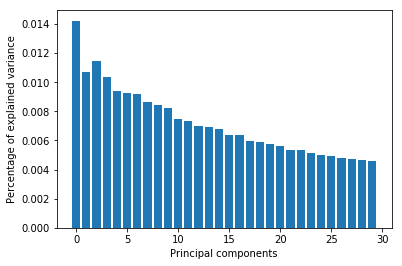

In [55]:
# Eboulis des valeurs propres
plt.figure()
abscisse = np.arange(30)
plt.bar(abscisse,svd.explained_variance_)
plt.xlabel("Principal components")
plt.ylabel("Percentage of explained variance" )
plt.show()

Nous remarquons d'après l'éboulis des valeurs propres que nous n'avons pas une composante qui explique bien nos données mais chacune des composantes (variables) est utile. Ainsi, l'ACP ne nous donneras pas un résultat très concluant mais nous allons quand même essayer. Nous remarquons cependant que 4 variables tirent l'informations, si on couple avec le graphe wordcloud on peut penser que ce sont cancer, chimiothérapie, radiothérapie et sein.

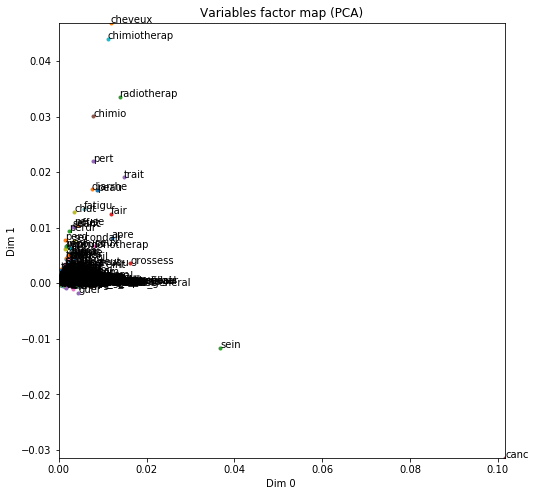

In [43]:
# composantes principales
C = svd.fit(X).transform(X)

#la svd affiche l'acp centree reduite
#on multiplie toutes nos composantes principales par une constante pour avoir des graphes plus visibles

#composante 0 & 1
coord10=svd.components_[0]*np.sqrt(svd.explained_variance_[0])
coord20=svd.components_[1]*np.sqrt(svd.explained_variance_[1])

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)

nom = vec.get_feature_names()
for i, j,nom in zip(coord10,coord20,nom):
    ax.plot(i, j, marker=".")
    ax.text(i, j,nom)
    #plt.arrow(0,0,i,j,color='r')
ax.set_xlim((min(coord10),max(coord10)))
ax.set_ylim((min(coord20),max(coord20)))

plt.title("Variables factor map (PCA)")
ax.set_xlabel('Dim 0 ')
ax.set_ylabel('Dim 1')
plt.show()

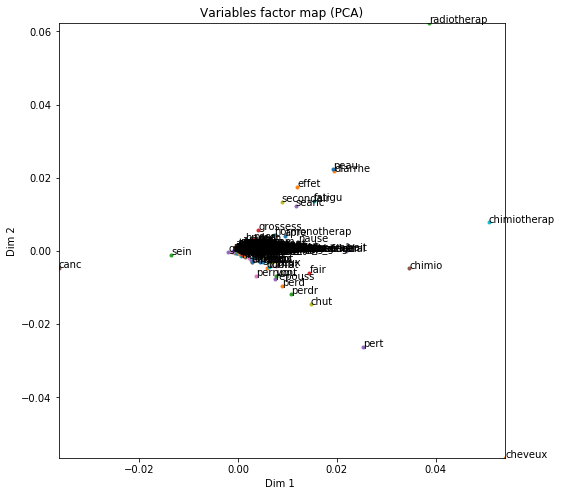

In [44]:
#composante 1 & 2
coord11=svd.components_[1]*np.sqrt(svd.explained_variance_[0])
coord21=svd.components_[2]*np.sqrt(svd.explained_variance_[1])

fig = plt.figure(figsize=(8,8)) # a enlever si on veut faire un subplot fourni
ax = fig.add_subplot(1, 1, 1)
nom = vec.get_feature_names()
for i, j,nom in zip(coord11,coord21,nom):
    ax.plot(i, j, marker=".")
    ax.text(i, j,nom)
    #plt.arrow(0,0,i,j,color='r')
ax.set_xlim((min(coord11),max(coord11)))
ax.set_ylim((min(coord21),max(coord21)))

plt.title("Variables factor map (PCA)")
ax.set_xlabel('Dim 1 ')
ax.set_ylabel('Dim 2')
plt.show()

Nous remarquons en effet que les variables chimiothérapie, radiothérapie, cancer semblent jouer un rôle important dans la caractérisation de nos données. Nous remarquons également l'apparition de la variable cheveux dans les composantes principales. Nous souhaiterions maintenant pouvoir mieux comprendre les axes principaux et attribuer des catégories à un ou plusieurs axes. Pour cela nous allons représenter les individus dans le plan factoriel.

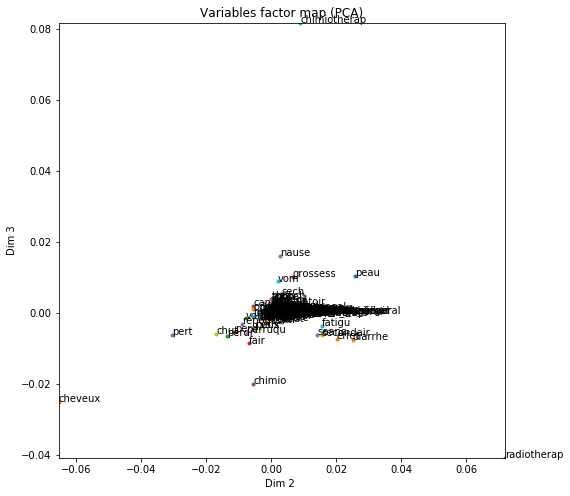

In [45]:
 #composante 2 & 3
coord12=svd.components_[2]*np.sqrt(svd.explained_variance_[0])
coord22=svd.components_[3]*np.sqrt(svd.explained_variance_[1])

fig = plt.figure(figsize=(8,8)) # a enlever si on veut faire un subplot fourni
ax = fig.add_subplot(1, 1, 1)
nom = vec.get_feature_names()
for i, j,nom in zip(coord12,coord22,nom):
    ax.plot(i, j, marker=".")
    ax.text(i, j,nom)
    #plt.arrow(0,0,i,j,color='r')
ax.set_xlim((min(coord12),max(coord12)))
ax.set_ylim((min(coord22),max(coord22)))

plt.title("Variables factor map (PCA)")
ax.set_xlabel('Dim 2 ')
ax.set_ylabel('Dim 3')
plt.show()

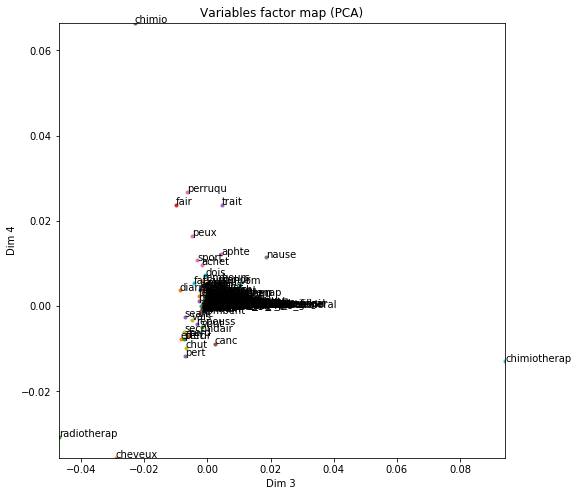

In [46]:
#composante 3 & 4
coord13=svd.components_[3]*np.sqrt(svd.explained_variance_[0])
coord23=svd.components_[4]*np.sqrt(svd.explained_variance_[1])

fig = plt.figure(figsize=(8,8)) # a enlever si on veut faire un subplot fourni
ax = fig.add_subplot(1, 1, 1)
nom = vec.get_feature_names()
for i, j,nom in zip(coord13,coord23,nom):
    ax.plot(i, j, marker=".")
    ax.text(i, j,nom)
    #plt.arrow(0,0,i,j,color='r')
ax.set_xlim((min(coord13),max(coord13)))
ax.set_ylim((min(coord23),max(coord23)))

plt.title("Variables factor map (PCA)")
ax.set_xlabel('Dim 3 ')
ax.set_ylabel('Dim 4')
plt.show()

Pour les composantes 3 et 4 nous remarquons l'apparition de la variable perruque en plus de la présence des variables précédentes. Nous allons réaliser une ACP sur les 4 premiers plans factoriels afin de visualiser au mieux les liens entre les différentes variables et les catégories (individus).

In [47]:
#collections.Counter([k[:2] for k in data_train_clean["Intent"].values])


Nous avons ici les macros catégories que nous pourrons utiliser par la suite afin de réaliser de nouveau une exploration des données.

In [87]:
intent = data_train_clean["Intent"] # catégorie

color_seq = [] #liste de couleurs


#on associe à chaque individu une couleur en fonction de sa classe
for k in range(int(np.shape(question)[0])):
    if intent[k] == '#6-49_TRTEINS_Peau' : color_seq.append("black")
    elif intent[k] == '#6-97_TRTEINS_Nausees_Vomissements': color_seq.append("red")
    elif intent[k] == '#6-92_TRTEINS_Diarrhee': color_seq.append("green")
    elif intent[k] == '#2-130_QVDP_Alimentation': color_seq.append("magenta")
    else : color_seq.append("blue")

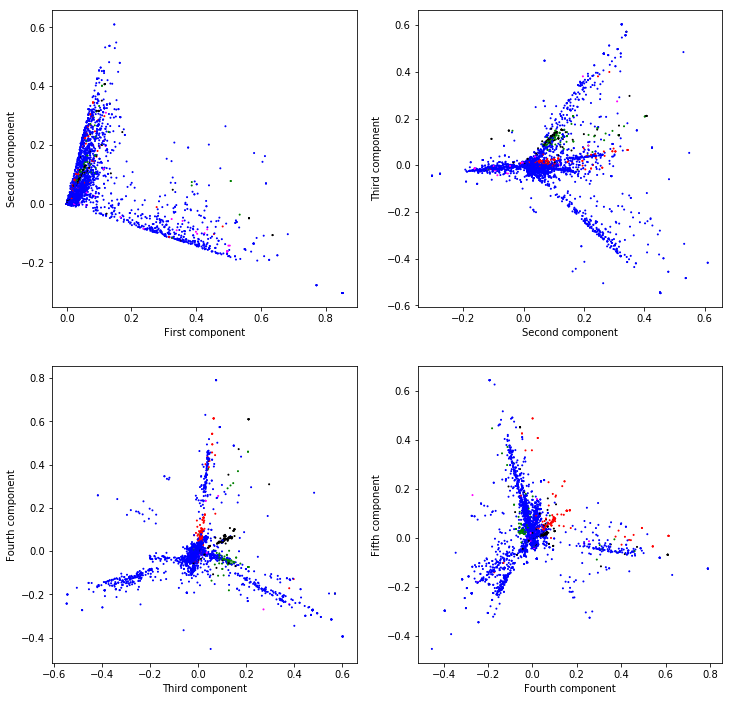

In [88]:
fig = plt.figure(figsize=(12,12))
# premier plan factoriel
ax = fig.add_subplot(2,2,1)
ax.scatter(C[:,0], C[:,1], s=1,c = color_seq)
plt.xlabel("First component")
plt.ylabel("Second component")


# deuxieme plan factoriel
ax = fig.add_subplot(2,2,2)
ax.scatter(C[:,1], C[:,2], s=1,c = color_seq)
plt.xlabel("Second component")
plt.ylabel("Third component")
# troisieme plan factoriel
ax = fig.add_subplot(2, 2, 3)
ax.scatter(C[:,2], C[:,3], s=1,c = color_seq)
plt.xlabel("Third component")
plt.ylabel("Fourth component")
# quatrieme plan factoriel
ax = fig.add_subplot(2, 2, 4)
ax.scatter(C[:,3], C[:,4], s=1,c = color_seq)
plt.xlabel("Fourth component")
plt.ylabel("Fifth component")
plt.show()

In [76]:
intent = data_train_clean["Intent"] # catégorie

color_seq = [] #liste de couleurs


#on associe à chaque individu une couleur en fonction de sa classe
for k in range(int(np.shape(question)[0])):
    if intent[k] == '#6-49_TRTEINS_Peau' : color_seq.append("black")
    elif intent[k] == '#6-97_TRTEINS_Nausees_Vomissements': color_seq.append("red")
    elif intent[k] == '#6-92_TRTEINS_Diarrhee': color_seq.append("green")
    elif intent[k] == '#2-130_QVDP_Alimentation': color_seq.append("magenta")
    else : color_seq.append("None")

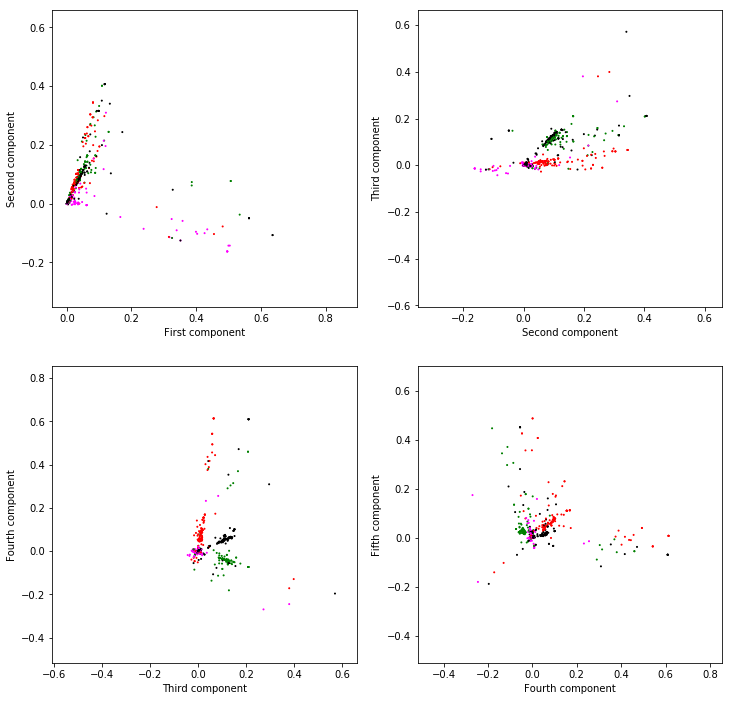

In [84]:
fig = plt.figure(figsize=(12,12))
# premier plan factoriel
ax = fig.add_subplot(2,2,1)
ax.scatter(C[:,0], C[:,1], s=1,c = color_seq)
plt.xlabel("First component")
plt.ylabel("Second component")

# deuxieme plan factoriel
ax = fig.add_subplot(2,2,2)
ax.scatter(C[:,1], C[:,2], s=1,c = color_seq)
plt.xlabel("Second component")
plt.ylabel("Third component")
# troisieme plan factoriel
ax = fig.add_subplot(2, 2, 3)
ax.scatter(C[:,2], C[:,3], s=1,c = color_seq)
plt.xlabel("Third component")
plt.ylabel("Fourth component")

# quatrieme plan factoriel
ax = fig.add_subplot(2, 2, 4)
ax.scatter(C[:,3], C[:,4], s=1,c = color_seq)
plt.xlabel("Fourth component")
plt.ylabel("Fifth component")
plt.show()

Nous observons 2 grands axes qui se dégagent selon les composantes 0 et 1. Les individus jaunes (alimentation) semblent être présents selon la composante horizontale (cancer et sein). Nous remarquons trois grands axes sur le graphe des individus selon les composantes 1 et 2. Nous pouvons également relevé la présence des individus rouges (nausées et vomissement) autour de l'axe horizontale (chimiothérapie) ou celle des individus noirs et verts (traitement peau et traitement diarrée) autour de l'axe vertical (radiothérapie et diarrée). 

In [50]:
int(np.shape(question)[0])

4511

In [51]:
print(tfidf.toarray()[0,324])
print(tfidf.nonzero())

0.0
(array([   0,    0,    0, ..., 4509, 4510, 4510], dtype=int32), array([1911,  575,  960, ...,  962,  218, 1496], dtype=int32))


In [52]:
print(np.shape(tfidf.nonzero()))
print(tfidf.nonzero())

(2, 13358)
(array([   0,    0,    0, ..., 4509, 4510, 4510], dtype=int32), array([1911,  575,  960, ...,  962,  218, 1496], dtype=int32))


In [53]:
data_train.iloc[k]

Question               je pus de la bouche
Intent      #6-93_TRTEINS_Mauvaise_Haleine
BlockId           5993f227e4b068eebe2d6550
Action                         wiki_cancer
Name: 4060, dtype: object

In [54]:
#6-97_TRTEINS_Nausees_Vomissements             135
#6-92_TRTEINS_Diarrhee                         129
#2-130_QVDP_Alimentation                       114